In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import missingno as msno
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

#In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). 
#In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. 
#Features without these designations are either continuous or ordinal. 
#Values of -1 indicate that the feature was missing from the observation. 
#The target columns signifies whether or not a claim was filed for that policy holder.

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("List of all columns in train set:\n" + str(list(train)) + "\n")
print("Total rows in train set:", len(train))
print("Total rows in test set:", len(test))

train.head()

List of all columns in train set:
['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']

Total rows in train set: 595212
Total rows in test set: 892816


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [36]:
#Submissions are evaluated using the Normalized Gini Coefficient.
#Let's define the Normalized Gini Coefficient function.

def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert(len(actual) == len(pred))
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

In [37]:
print("Before visualizing the data, let's first replace -1 by NaN in our datasets.\n")

train = train.replace(-1, np.NaN)
test = test.replace(-1, np.NaN)

Before visualizing the data, let's first replace -1 by NaN in our datasets.



In [38]:
#Let's do a first processing step by getting categorical and binary features.

excluded_cols = ['id', 'target']

cat_features = [f for f in list(train) if f.endswith('_cat')]
bin_features = [f for f in list(train) if f.endswith('_bin')]
cat_bin_features = [f for f in list(train) if f.endswith('_cat') or f.endswith('_bin')]
non_cat_features = [f for f in list(train) if f not in cat_bin_features and f not in excluded_cols]

print("Categorical features:\n" + str(cat_features) + "\n")
print("Binary features:\n" + str(bin_features) + "\n")
print("Continuous/Ordinal features:\n" + str(non_cat_features) + "\n")
train.head()

Categorical features:
['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']

Binary features:
['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']

Continuous/Ordinal features:
['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14']



,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1.0,2,0.0,0.0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2.0,0,1.0,0.0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [39]:
print("""Let's separate columns by feature type (ind, reg, car, calc)
then by data type (cat, bin, con).""")

ind_cols = [col for col in train.columns if '_ind_' in col]
reg_cols = [col for col in train.columns if '_reg_' in col]
car_cols = [col for col in train.columns if '_car_' in col]
calc_cols = [col for col in train.columns if '_calc_' in col]

ind_cat = [col for col in ind_cols if '_cat' in col]
reg_cat = [col for col in reg_cols if '_cat' in col]
car_cat = [col for col in car_cols if '_cat' in col]
calc_cat = [col for col in calc_cols if '_cat' in col]

ind_bin = [col for col in ind_cols if '_bin' in col]
reg_bin = [col for col in reg_cols if '_bin' in col]
car_bin = [col for col in car_cols if '_bin' in col]
calc_bin = [col for col in calc_cols if '_bin' in col]

ind_con = [col for col in ind_cols if ('_bin' not in col and '_cat' not in col)]
reg_con = [col for col in reg_cols if ('_bin' not in col and '_cat' not in col)]
car_con = [col for col in car_cols if ('_bin' not in col and '_cat' not in col)]
calc_con = [col for col in calc_cols if ('_bin' not in col and '_cat' not in col)]

Let's separate columns by feature type (ind, reg, car, calc)
then by data type (cat, bin, con).


Let's take a look at the correlation matrixes
over our variables.


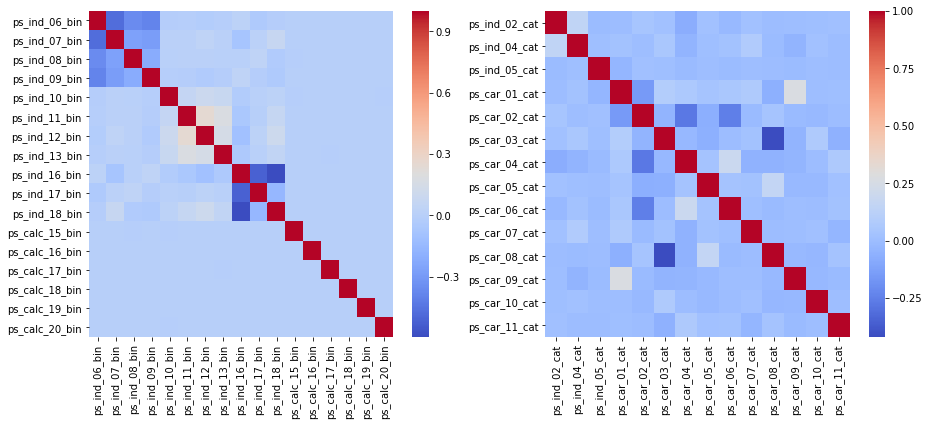

In [6]:
print("""Let's take a look at the correlation matrixes
over our variables.""")

f,axarray = plt.subplots(1,2,figsize=(15,6))
plt.xticks(rotation='vertical')

sns.heatmap(train[bin_features].corr(),ax=axarray[0],cmap="coolwarm")
sns.heatmap(train[cat_features].corr(),ax=axarray[1],cmap="coolwarm")

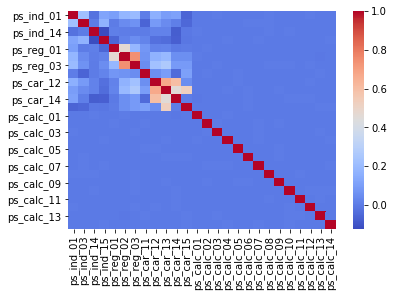

In [7]:
sns.heatmap(train[non_cat_features].corr(),cmap="coolwarm")

In [40]:
print("""As calc continuous features are not related either to target or to any variable related to target, we'll drop them.""")

train = train.drop(calc_con, axis=1)
test = test.drop(calc_con, axis=1)

non_cat_features = [f for f in non_cat_features if f not in calc_con]

As calc continuous features are not related either to target or to any variable related to target, we'll drop them.


Let's visualize the frequency of NaN in the categorical columns of our train set.



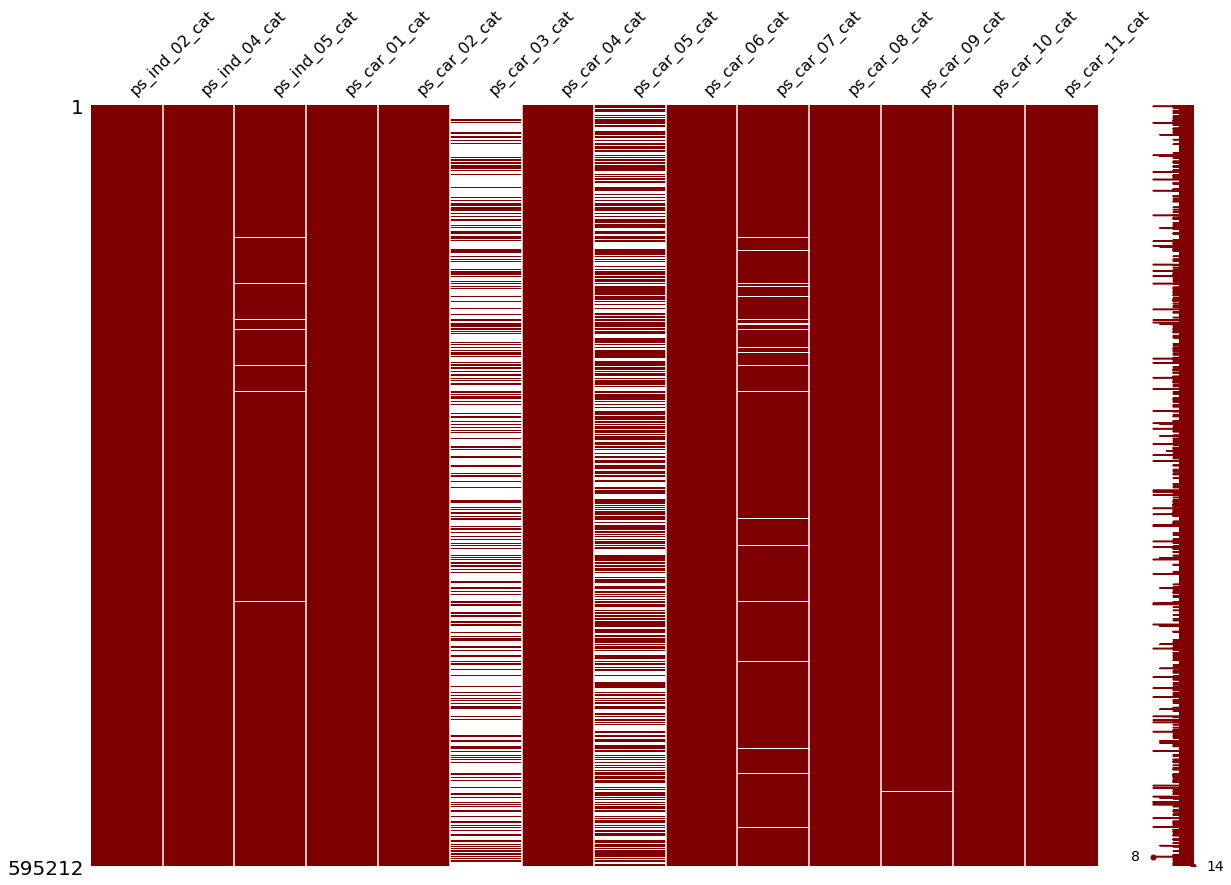


Let's to the same for the binary columns.



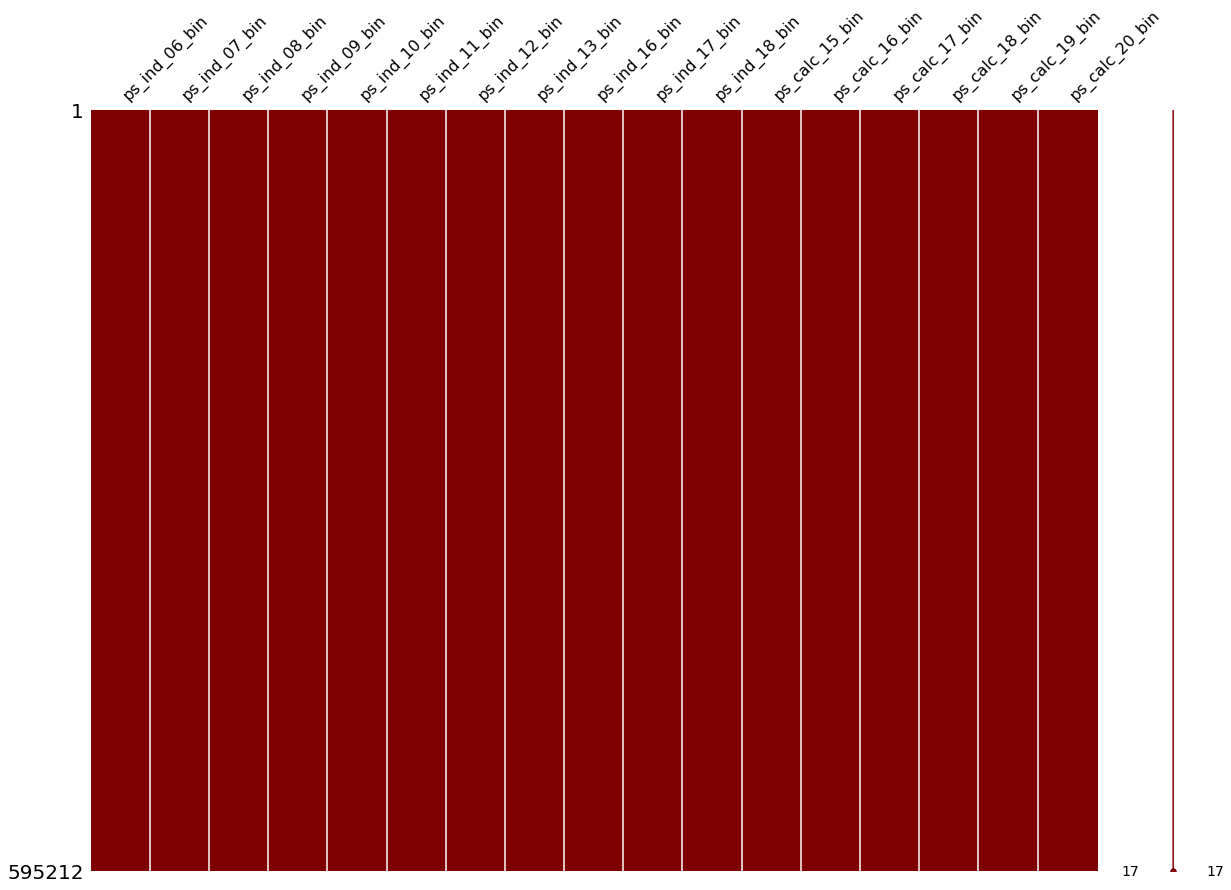


Let's to the same for all the columns which are not categorical neither binary.



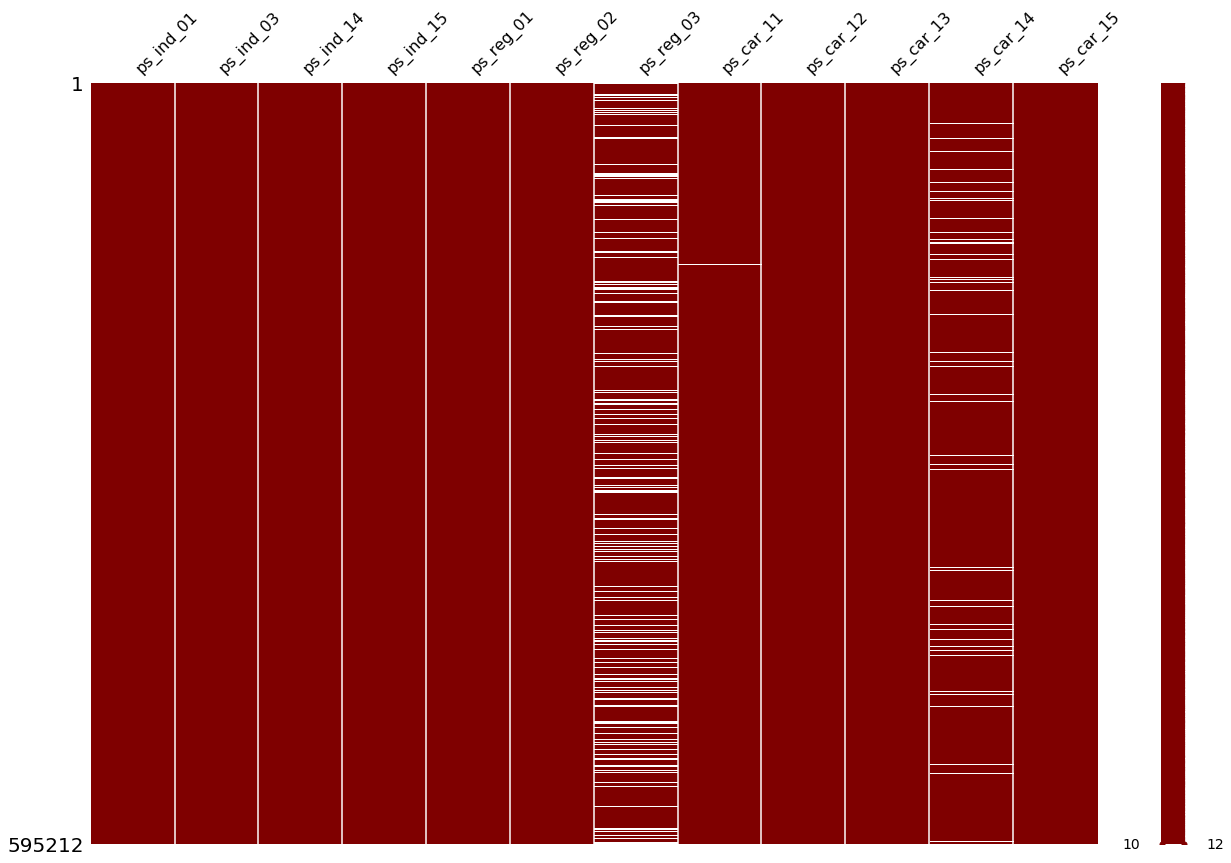


It is very clear that some columns have a large share of NaN values.
For these features, if they are categorical we will simply extract NaN as a dummy feature using the kwarg dummy_na = True.
Binary features don't seem to contain NaN values, we will make sure of that programmatically and eventually drop the records
containing some.
For features which aren't binary neither categorical, the question is a bit trickier: should we replace NaN by Median ?
Column ps_reg_03 contains so many NaN that it could potentially introduce a bias in the feature if we do so.


In [41]:
print("Let's visualize the frequency of NaN in the categorical columns of our train set.\n")
msno.matrix(df=train[cat_features], figsize=(20,14), color=(0.5,0,0))

print("\nLet's to the same for the binary columns.\n")
msno.matrix(df=train[bin_features], figsize=(20,14), color=(0.5,0,0))

print("\nLet's to the same for all the columns which are not categorical neither binary.\n")
msno.matrix(df=train[non_cat_features], figsize=(20,14), color=(0.5,0,0))

print("""\nIt is very clear that some columns have a large share of NaN values.
For these features, if they are categorical we will simply extract NaN as a dummy feature using the kwarg dummy_na = True.
Binary features don't seem to contain NaN values, we will make sure of that programmatically and eventually drop the records
containing some.
For features which aren't binary neither categorical, the question is a bit trickier: should we replace NaN by Median ?
Column ps_reg_03 contains so many NaN that it could potentially introduce a bias in the feature if we do so.""")

In [42]:
print("""Now, let's calculate the % of NaN values in the features as mentioned above.\n""")

def missing_values_table(df): 
    l = len(df)
    mis_val = df.isnull().sum().reset_index(name='count_nan')
    mis_val['pcent_total'] = mis_val.count_nan.apply(lambda x: x/l)
    mis_val = mis_val[mis_val.count_nan > 0].sort_values('pcent_total', ascending=False)
    return mis_val

print(missing_values_table(train))
print("""\nBased on the table above, we will do the following:
- ps_car_03_cat, ps_car_05_cat, ps_car_07_cat, ps_ind_05_cat: extract NaN as dummy feature using kwarg dummy_na = True.
- ps_reg_03, ps_car_14: replace NaN by column median.
- Other columns: drop rows containing NaN values.
""")

Now, let's calculate the % of NaN values in the features as mentioned above.

            index  count_nan  pcent_total
25  ps_car_03_cat     411231     0.690898
27  ps_car_05_cat     266551     0.447825
22      ps_reg_03     107772     0.181065
37      ps_car_14      42620     0.071605
29  ps_car_07_cat      11489     0.019302
6   ps_ind_05_cat       5809     0.009760
31  ps_car_09_cat        569     0.000956
3   ps_ind_02_cat        216     0.000363
23  ps_car_01_cat        107     0.000180
5   ps_ind_04_cat         83     0.000139
24  ps_car_02_cat          5     0.000008
34      ps_car_11          5     0.000008
35      ps_car_12          1     0.000002

Based on the table above, we will do the following:
- ps_car_03_cat, ps_car_05_cat, ps_car_07_cat, ps_ind_05_cat: extract NaN as dummy feature using kwarg dummy_na = True.
- ps_reg_03, ps_car_14: replace NaN by column median.
- Other columns: drop rows containing NaN values.



In [43]:
cols_na_to_median = ['ps_reg_03', 'ps_car_14', 'ps_car_11', 'ps_car_12']

print("Now, we can replace NaN values with the column medians for these columns:\n" + str(cols_na_to_median))

def na_to_median(df, cols):
    for c in cols:
        med = df[c].median()
        df[c] = df[c].fillna(med)
    return df

train = na_to_median(train, cols_na_to_median)
test = na_to_median(test, cols_na_to_median)

verif_train = train[cols_na_to_median].isnull().sum()
verif_test = test[cols_na_to_median].isnull().sum()

Now, we can replace NaN values with the column medians for these columns:
['ps_reg_03', 'ps_car_14', 'ps_car_11', 'ps_car_12']


In [44]:
print("Let's make sure now that only the categorical columns still have NaN values:\n")

print(missing_values_table(train))
print(missing_values_table(test))

print("""\nPerfect !!!""")

Let's make sure now that only the categorical columns still have NaN values:

            index  count_nan  pcent_total
25  ps_car_03_cat     411231     0.690898
27  ps_car_05_cat     266551     0.447825
29  ps_car_07_cat      11489     0.019302
6   ps_ind_05_cat       5809     0.009760
31  ps_car_09_cat        569     0.000956
3   ps_ind_02_cat        216     0.000363
23  ps_car_01_cat        107     0.000180
5   ps_ind_04_cat         83     0.000139
24  ps_car_02_cat          5     0.000008
            index  count_nan  pcent_total
24  ps_car_03_cat     616911     0.690972
26  ps_car_05_cat     400359     0.448423
28  ps_car_07_cat      17331     0.019412
5   ps_ind_05_cat       8710     0.009756
30  ps_car_09_cat        877     0.000982
2   ps_ind_02_cat        307     0.000344
22  ps_car_01_cat        160     0.000179
4   ps_ind_04_cat        145     0.000162
23  ps_car_02_cat          5     0.000006

Perfect !!!


In [45]:
print("""Let's check the distinct values in our categorical variables
to avoid having dimensionality issues after dummification.
""")

for f in cat_features:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Let's check the distinct values in our categorical variables
to avoid having dimensionality issues after dummification.

Variable ps_ind_02_cat has 4 distinct values
Variable ps_ind_04_cat has 2 distinct values
Variable ps_ind_05_cat has 7 distinct values
Variable ps_car_01_cat has 12 distinct values
Variable ps_car_02_cat has 2 distinct values
Variable ps_car_03_cat has 2 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_05_cat has 2 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 2 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 5 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


In [46]:
print("""As ps_car_11_cat has 104 distinct values, we 
will simply replace theses values by their supervised ratio.""")

cat_perc = train[['ps_car_11_cat', 'target']].groupby(['ps_car_11_cat'],as_index=False).mean().reset_index()

cat_perc.rename(columns={'target': 'ps_car_11_cat_tm'}, inplace=True)

train_temp = pd.merge(train, cat_perc, how='inner', on='ps_car_11_cat')
test_temp = pd.merge(test, cat_perc, how='inner', on='ps_car_11_cat')

train_temp.drop('ps_car_11_cat', axis=1, inplace=True)
test_temp.drop('ps_car_11_cat', axis=1, inplace=True)

non_cat_features.append('ps_car_11_cat_tm')
car_con.append('ps_car_11_cat_tm')

cat_features.remove('ps_car_11_cat')
car_cat.remove('ps_car_11_cat')


As ps_car_11_cat has 104 distinct values, we 
will simply replace theses values by their supervised ratio.


In [47]:
print("""Next step: adding interaction variables for our intervals variables.""")

v = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 
    'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15']


poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions_train = pd.DataFrame(data=poly.fit_transform(train_temp[v]), columns=poly.get_feature_names(v))
interactions_test = pd.DataFrame(data=poly.fit_transform(test_temp[v]), columns=poly.get_feature_names(v))

interactions_train.drop(v, axis=1, inplace=True)
interactions_test.drop(v, axis=1, inplace=True)

# Merge the interaction variables to the train data
print('Before creating interactions we have {} variables in train_temp'.format(train_temp.shape[1]))
train_temp = pd.concat([train_temp, pd.DataFrame(data=interactions_train, columns=interactions_train.columns)], axis=1)
test_temp = pd.concat([test_temp, pd.DataFrame(data=interactions_test, columns=interactions_test.columns)], axis=1)
print('After creating interactions we have {} variables in train_temp'.format(train_temp.shape[1]))


Next step: adding interaction variables for our intervals variables.
Before creating interactions we have 46 variables in train_temp
After creating interactions we have 74 variables in train_temp


In [48]:
print("Next step: adding dummy features for our categorical variables.")
print('Before dummification we have {} variables in train set.'.format(train_temp.shape[1]))

train_dummies = pd.get_dummies(train_temp, prefix=cat_features, columns=cat_features, dummy_na=True)
test_dummies = pd.get_dummies(test_temp, prefix=cat_features, columns=cat_features, dummy_na=True)

print('After dummification we have {} variables in train set.'.format(train_dummies.shape[1]))

Next step: adding dummy features for our categorical variables.
Before dummification we have 74 variables in train set.
After dummification we have 145 variables in train set.


In [17]:
print("""It would be interesting to look at features importance now, and keep only the Nth most important features.""")

X_train = train_dummies.drop(['id', 'target'], axis=1)
Y_train = train_dummies['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, Y_train)
importances = rf.feature_importances_

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

It would be interesting to look at features importance now, and keep only the Nth most important features.
 1) ps_reg_03 ps_car_13            0.030939
 2) ps_car_13^2                    0.030063
 3) ps_car_13                      0.029973
 4) ps_car_12 ps_car_13            0.029657
 5) ps_car_13 ps_car_14            0.029642
 6) ps_reg_01 ps_car_13            0.029507
 7) ps_car_13 ps_car_15            0.029123
 8) ps_reg_03 ps_car_14            0.028422
 9) ps_reg_03 ps_car_12            0.027403
10) ps_reg_03 ps_car_15            0.027195
11) ps_reg_01 ps_reg_03            0.026173
12) ps_reg_02 ps_car_13            0.026172
13) ps_reg_03                      0.025702
14) ps_reg_03^2                    0.025701
15) ps_car_14 ps_car_15            0.023173
16) ps_reg_02 ps_reg_03            0.022725
17) ps_reg_01 ps_car_14            0.022671
18) ps_ind_15                      0.021880
19) ps_ind_03                      0.021748
20) ps_reg_02 ps_car_14            0.020937
21) ps_car_12

In [18]:
from sklearn.feature_selection import SelectFromModel

print("""Now let's use SelectFromModel to reduce the amount of variables we'll train our model with.""")

sfm = SelectFromModel(rf, threshold='median', prefit=True)
print('Number of features before selection: {}'.format(train_dummies.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Now let's use SelectFromModel to reduce the amount of variables we'll train our model with.
Number of features before selection: 145
Number of features after selection: 72


In [49]:
#Just copied the selected variables to avoid running the features importance calculation (time saved)
selected_vars = ['ps_reg_03 ps_car_13', 'ps_car_13^2', 'ps_car_13', 'ps_car_12 ps_car_13', 'ps_car_13 ps_car_14', 'ps_reg_01 ps_car_13', 'ps_car_13 ps_car_15', 'ps_reg_03 ps_car_14', 'ps_reg_03 ps_car_12', 'ps_reg_03 ps_car_15', 'ps_reg_01 ps_reg_03', 'ps_reg_02 ps_car_13', 'ps_reg_03', 'ps_reg_03^2', 'ps_car_14 ps_car_15', 'ps_reg_02 ps_reg_03', 'ps_reg_01 ps_car_14', 'ps_ind_15', 'ps_ind_03', 'ps_reg_02 ps_car_14', 'ps_car_12 ps_car_14', 'ps_car_14^2', 'ps_car_14', 'ps_car_11_cat_tm', 'ps_reg_02 ps_car_15', 'ps_reg_01 ps_car_15', 'ps_car_12 ps_car_15', 'ps_ind_01', 'index', 'ps_reg_02 ps_car_12', 'ps_reg_01 ps_car_12', 'ps_reg_01 ps_reg_02', 'ps_car_15^2', 'ps_car_15', 'ps_reg_02^2', 'ps_reg_02', 'ps_car_12', 'ps_car_12^2', 'ps_reg_01', 'ps_reg_01^2', 'ps_car_11', 'ps_calc_17_bin', 'ps_calc_16_bin', 'ps_calc_19_bin', 'ps_calc_18_bin', 'ps_car_01_cat_11.0', 'ps_ind_04_cat_0.0', 'ps_ind_04_cat_1.0', 'ps_car_09_cat_2.0', 'ps_ind_16_bin', 'ps_ind_02_cat_1.0', 'ps_ind_05_cat_0.0', 'ps_calc_20_bin', 'ps_car_05_cat_1.0', 'ps_ind_07_bin', 'ps_car_05_cat_0.0', 'ps_car_01_cat_7.0', 'ps_ind_02_cat_2.0', 'ps_ind_17_bin', 'ps_calc_15_bin', 'ps_car_09_cat_0.0', 'ps_ind_06_bin', 'ps_ind_08_bin', 'ps_ind_18_bin', 'ps_ind_09_bin', 'ps_car_05_cat_nan', 'ps_car_06_cat_1.0', 'ps_car_06_cat_0.0', 'ps_car_06_cat_11.0', 'ps_car_01_cat_10.0', 'ps_car_09_cat_1.0', 'ps_car_03_cat_1.0']

['ps_reg_03 ps_car_13', 'ps_car_13^2', 'ps_car_13', 'ps_car_12 ps_car_13', 'ps_car_13 ps_car_14', 'ps_reg_01 ps_car_13', 'ps_car_13 ps_car_15', 'ps_reg_03 ps_car_14', 'ps_reg_03 ps_car_12', 'ps_reg_03 ps_car_15', 'ps_reg_01 ps_reg_03', 'ps_reg_02 ps_car_13', 'ps_reg_03', 'ps_reg_03^2', 'ps_car_14 ps_car_15', 'ps_reg_02 ps_reg_03', 'ps_reg_01 ps_car_14', 'ps_ind_15', 'ps_ind_03', 'ps_reg_02 ps_car_14', 'ps_car_12 ps_car_14', 'ps_car_14^2', 'ps_car_14', 'ps_car_11_cat_tm', 'ps_reg_02 ps_car_15', 'ps_reg_01 ps_car_15', 'ps_car_12 ps_car_15', 'ps_ind_01', 'index', 'ps_reg_02 ps_car_12', 'ps_reg_01 ps_car_12', 'ps_reg_01 ps_reg_02', 'ps_car_15^2', 'ps_car_15', 'ps_reg_02^2', 'ps_reg_02', 'ps_car_12', 'ps_car_12^2', 'ps_reg_01', 'ps_reg_01^2', 'ps_car_11', 'ps_calc_17_bin', 'ps_calc_16_bin', 'ps_calc_19_bin', 'ps_calc_18_bin', 'ps_car_01_cat_11.0', 'ps_ind_04_cat_0.0', 'ps_ind_04_cat_1.0', 'ps_car_09_cat_2.0', 'ps_ind_16_bin', 'ps_ind_02_cat_1.0', 'ps_ind_05_cat_0.0', 'ps_calc_20_bin', 'ps_c

In [50]:
train_dummies = train_dummies.sample(frac=1).reset_index(drop=True)
X = train_dummies[selected_vars].values
Y = train_dummies[['target']].values
test_reduced = test_dummies[selected_vars].values

print(Y.shape)
print(X.shape)
print(test_reduced.shape)

(595212, 1)
(595212, 72)
(892816, 72)


In [70]:
print("""The logistic regression model gives us a Gini Normalized Score 
of 0.259. We will try to tune XGBoost now to see if we can improve this
score.""")

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

# Create an XGBoost-compatible metric from Gini
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]


#Creating KFold
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

#Creating submission dataframe

id_test = test_dummies['id'].values

sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = np.zeros_like(id_test)

# Set xgboost parameters
params = {}

#General params:
params['silent'] = 0

#Tree Booster params:

params['eta'] = 0.07
params['min_child_weight'] = 6
params['max_depth'] = 4
params['subsample'] = 0.8
params['colsample_bytree'] = 0.8
params['max_delta_step'] = 6.0

params['gamma'] = 10
params['reg_alpha'] = 8
params['reg_lambda'] = 1.3
params['scale_pos_weight'] = 1.33

#Learning Task parameters
params['objective'] = 'binary:logistic'

for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print('\n[Fold %d/%d]\n' % (i + 1, kfold))
    
    X_train, X_valid = X[train_index], X[test_index]
    Y_train, Y_valid = Y[train_index], Y[test_index]

    #Converting our data into XGB format
    d_train = xgb.DMatrix(X_train, Y_train)
    d_valid = xgb.DMatrix(X_valid, Y_valid)
    d_test = xgb.DMatrix(test_reduced)

    # This is the data xgboost will test on after eachboosting round
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    progress = dict()
    
    # Train the model! 
    # NB: We set early stopping at 50 just for evaluation purpose, could be lower for early stopping.
    # and the custom metric (maximize=True tells xgb that higher metric is better)

    mdl = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=13, feval=gini_xgb, maximize=True, verbose_eval=10, evals_result=progress)
    
    print('\n[Fold %d/%d Prediciton...]\n' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    sub['target'] += p_test/kfold


The logistic regression model gives us a Gini Normalized Score 
of 0.259. We will try to tune XGBoost now to see if we can improve this
score.

[Fold 1/5]

[0]	train-gini:0.177067	valid-gini:0.158287
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 13 rounds.
[10]	train-gini:0.224692	valid-gini:0.208647
[20]	train-gini:0.234781	valid-gini:0.21946
[30]	train-gini:0.246345	valid-gini:0.230061
[40]	train-gini:0.257101	valid-gini:0.236676
[50]	train-gini:0.267643	valid-gini:0.245942
[60]	train-gini:0.275398	valid-gini:0.252255
[70]	train-gini:0.282798	valid-gini:0.257101
[80]	train-gini:0.288324	valid-gini:0.261168
[90]	train-gini:0.293106	valid-gini:0.2643
[100]	train-gini:0.296643	valid-gini:0.26708
[110]	train-gini:0.300715	valid-gini:0.268866
[120]	train-gini:0.303405	valid-gini:0.270321
[130]	train-gini:0.306314	valid-gini:0.271661
[140]	train-gini:0.308479	valid-gini:0.272261
[150]	train-gini:0.31050

Now let's look at the learning curve of our model.


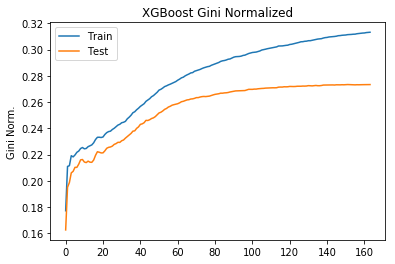

In [73]:
print("""Now let's look at the learning curve of our model.""")

#Plotting learning curve for Gini Normalized

epochs = len(progress['train']['gini'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, progress['train']['gini'], label='Train')
ax.plot(x_axis, progress['valid']['gini'], label='Test')
ax.legend()
plt.ylabel('Gini Norm.')
plt.title('XGBoost Gini Normalized')
plt.show()

In [72]:
sub.to_csv('submission_xgb.csv', index=False)